In [1]:
# Simulate decaying correlation. 

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyproj import Proj
from shapely.geometry import Point

## Load location data for industry p
Pass point coordinates to separate columns 'loc_x' and 'loc_y'.

Convert to metres (UTM, Easting Northing) so to have metrical units and work more confortably. However keep in mind there will be a little distortion

In [3]:
gpd.read_file('./data/locations_data/NG_point_1.shp').head()

,STATE,COUNTY,PLANT,ZIPCODE,STATUS,CAPACITY,geometry
0,CO,Weld,Redtail Gas Plant,80742,Active,20.0,POINT (-103.9806987444521 40.54616715790659)
1,AL,Mobile,Hatters Pond Gas Plant,36525,Active,70.0,POINT (-88.01355335527282 30.87934662953371)
2,TX,Scurry,Snyder Gasoline Plant,79549,Active,90.0,POINT (-100.6051852583855 33.02811065588871)
3,CO,Garfield,Hay Canyon Treating Facility,81524,Active,25.0,POINT (-108.9485560265749 39.20001702484542)
4,AL,Conecuh,Castleberry,36432,Active,9.0,POINT (-87.14239632743687 31.29116545735495)


In [4]:
# Either Natural Gas or Oil Refineries. Load and make a column called value.

industry_name = 'Natural Gas'
NG = gpd.read_file('./data/locations_data/NG_point_1.shp'); NG.crs = {'init': 'epsg:4326'}
NG['value'] = NG['CAPACITY']

industry_name = 'Oil Refineries'
OR = gpd.read_file('./data/locations_data/U.S._Petroleum_Refineries.shp')
OR['value'] = OR[[col for col in OR.columns if 'Mbpd' in col]].sum(1)
OR = OR.loc[~OR.State.isin(['Alaska', 'Hawaii'])] # Keep contiguous US

In [5]:
import numexpr as ne

def groupby_grid(df, log10_size, x_col, y_col):
    grouped = df.groupby([df[x_col].round(-log10_size), df[y_col].round(-log10_size)])
    return grouped

def flap(x, y, t, b, xm, ym):
    a = -np.sqrt((x-xm)**2 + (y-ym)**2)/b
    return t*ne.evaluate('exp(a)')/(2*b)


def sum_pdfs(df, num_int = 10, margin = 100, return_mesh = False):
#     min_ = df.min()
#     x_min = min_[-2] - margin; y_min = min_[-1] - margin
#     max_ = df.max()
#     x_max = max_[-2] + margin; y_max = max_[-1] + margin

    x_min = -1600; y_min = 2800
    x_max = 2300; y_max = 5600
    
    x = np.arange(x_min, x_max, num_int)
    y = np.arange(y_min, y_max, num_int)
    
    xx, yy = np.meshgrid(x, y, sparse=True)
    z_cum = np.zeros((len(y), len(x)))
    for v in df.values:
        z = flap(xx, yy, v[0], v[1], v[2], v[3])
        z_cum = z_cum + z
    if return_mesh:
        return x, y, z_cum
    else:
        return z_cum
    
def groupby_grid(df, log10_size, x_col, y_col):
    grouped = df.groupby([df[x_col].round(-log10_size), df[y_col].round(-log10_size)])
    return grouped

## Computation. Continuous and discrete cases.

In [6]:
# dist = [.3, 1, 3, 6, 10, 20, 30, 50, 75, 100, 300, 500]  # distances (km) used in letting corr decay
# # dist = [3, 30, 75, 100, 300]  # distances (km) used in letting corr decay
# dist = [10, 20, 30]  # distances (km) used in letting corr decay
# D = len(dist)
# N = 20

# # widths = np.array([1, 3, 10, 30, 100]) # influence radios in km
# widths = np.array([ 3, 30]) # influence radios in km
# B = len(widths)

# df_disc_list = []
# df_cont_list = []

# n_grids = 2
# n_industries = 2
# for j in range(n_industries):
    
#     indu_p = [NG, OR][j]
#     industry_name = ['Natural Gas', 'Oil Refineries'][j]
    
#     # Get coordinates in separate columns
#     loc_values = np.array([(p.x, p.y) for p in indu_p.geometry])
#     indu_p['loc_x'] = loc_values[:, 0]
#     indu_p['loc_y'] = loc_values[:, 1]

#     # Projection to UTM 14S (it's centered on US midwest).
#     myProj = Proj("+proj=utm +zone=14S, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

#     # Project
#     indu_p['loc_x'], indu_p['loc_y'] = myProj(indu_p['loc_x'].values, indu_p['loc_y'].values)
#     # Units from meters to km
#     indu_p['loc_x']  = indu_p['loc_x']/1e3; 
#     indu_p['loc_y']  = indu_p['loc_y']/1e3; 

#     # Check what we got so far
#     plt.scatter(indu_p['loc_x'], indu_p['loc_y'], s = indu_p['value']/5., alpha = .1)
#     plt.show()

In [92]:
# def flap(x, y, t, b, xm, ym):
#     a = -np.sqrt((x-xm)**2 + (y-ym)**2)/b
#     return t*ne.evaluate('exp(a)')/(2*b)

def sum_pdfs(df, num_int = 15, margin = 100, return_mesh = False):
#     min_ = df.min()
#     x_min = min_[-2] - margin; y_min = min_[-1] - margin
#     max_ = df.max()
#     x_max = max_[-2] + margin; y_max = max_[-1] + margin

    x_min = -1600; y_min = 2800
    x_max = 2300; y_max = 5600
    
    x = np.arange(x_min, x_max, num_int)
    y = np.arange(y_min, y_max, num_int)
    
    xx, yy = np.meshgrid(x, y, sparse=True)
    z_cum = np.zeros((len(y), len(x)))
    
    for v in df.values:
        t = v[0]; b = v[1]; xm = v[2]; ym = v[3];
        d2 = (xx-xm)**2 + (yy-ym)**2
        a = -np.sqrt(d2)/b
        th = np.quantile(a, .9995)
        i_ = np.where((a > th).sum(1))[0] # rows
        j_ = np.where((a > th).sum(0))[0] # columns
        a_ = a[i_][:, j_]

        z_ = t*ne.evaluate('exp(a_)')/(2*b)
        z = np.zeros(a.shape); 
        z[i_[0]:i_[0] + len(i_), j_[0] :j_[0] + len(j_)]= z_ ### I have to do this shit because z[i_][:, j_] is not taken

        z_cum = z_cum + z
        
    if return_mesh:
        return x, y, z_cum
    else:
        return z_cum

### CREATE LOCATIONS INFO

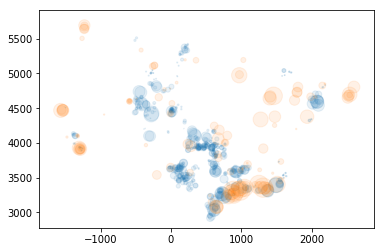

In [189]:
dist = [.3, 1, 3, 6, 10, 20, 30, 50, 75, 100, 300, 500]  # distances (km) used in letting corr decay
# dist = [3, 30, 75, 100, 300]  # distances (km) used in letting corr decay
# dist = [10, 20, 30]  # distances (km) used in letting corr decay
D = len(dist)
N = 30

widths = np.array([1, 3, 10, 30, 100]) # influence radios in km
# widths = np.array([ 3, 30]) # influence radios in km
B = len(widths)

n_industries = 2

indu_loc_info = []

for j in range(n_industries):
    indu_p = [NG, OR][j]
    
    # Get coordinates in separate columns
    loc_values = np.array([(p.x, p.y) for p in indu_p.geometry])
    indu_p['loc_x'] = loc_values[:, 0]
    indu_p['loc_y'] = loc_values[:, 1]

    # Projection to UTM 14S (it's centered on US midwest).
    myProj = Proj("+proj=utm +zone=14S, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    # Project
    indu_p['loc_x'], indu_p['loc_y'] = myProj(indu_p['loc_x'].values, indu_p['loc_y'].values)
    # Units from meters to km
    indu_p['loc_x']  = indu_p['loc_x']/1e3; 
    indu_p['loc_y']  = indu_p['loc_y']/1e3; 

    # Check what we got so far
    plt.scatter(indu_p['loc_x'], indu_p['loc_y'], s = indu_p['value']/5., alpha = .1)
    
    ### Create jittered Q industry locations
    # For industry q, copy industry p, and apply an increasing jitter. 
    indu_q = indu_p.copy()[['value', 'geometry']].reset_index(drop = True)
    
    cov_results = np.zeros((D, N))
    x_0 = indu_p['loc_x']
    y_0 = indu_p['loc_y']

    for d in range(D):
        # For each distance d
        for n in range(N):
            # For each repetition n. Set the name of the x, y columns. 
            x_col = 'loc_d'+str(d)+'n'+str(n)+'_x'
            y_col = 'loc_d'+str(d)+'n'+str(n)+'_y'

            # Random choose angle, shift original x, y by d.
            angles = np.pi * np.random.uniform(0, 2, len(indu_q))
            x_d = dist[d] * np.cos(angles); y_d = dist[d] * np.sin(angles)
            # jittered q locations to column
            jit_values = np.array([x_0, y_0]).T + np.array([x_d, y_d]).T

            indu_q[x_col] = jit_values[:, 0]
            indu_q[y_col] = jit_values[:, 1]
            
    indu_loc_info += [(indu_p, indu_q)]
            

### CONTINUOUS EXPERIMENT (slow)

In [190]:
df_cont_list = []
for j in range(n_industries):
    industry_name = ['Natural Gas', 'Oil Refineries'][j]
    print(industry_name)
    
    indu_p, indu_q = indu_loc_info[j]
    for b in range(B):
        print(b)
        int_results = np.zeros((D, N))
        for d in range(D):
            print(d)
            for n in range(N):
                print(n)
                x_col = 'loc_d'+str(d)+'n'+str(n)+'_x'
                y_col = 'loc_d'+str(d)+'n'+str(n)+'_y'

                indu_p['b'] = widths[b]
                indu_q['b'] = widths[b]

                z_cump = sum_pdfs(indu_p[['value', 'b', 'loc_x', 'loc_y']]) ## Lento?
                z_cumq = sum_pdfs(indu_q[['value', 'b', x_col, y_col]])
                
                if z_cump.sum() == 0: print('z_cump.sum() = 0')
                if z_cumq.sum() == 0: print('z_cumq.sum() = 0')
    
                # Make them PDFs. That is normalize by their sum, so they sum to 1
                z_cump = z_cump/sum(sum(z_cump))
                z_cumq = z_cumq/sum(sum(z_cumq))

                int_results[d, n] = sum(sum(z_cump * z_cumq))/sum(sum(z_cump * z_cump))
                
        mn = int_results.mean(1)
        q25 = np.quantile(int_results, .25, axis = 1)
        q75 = np.quantile(int_results, .75, axis = 1)
        df_cont = pd.DataFrame(np.vstack([mn, q25, q75]).T, index = dist, columns=['mean', 'q25', 'q75'])

        df_cont.index.name = 'b_dist'
        df_cont['b_width'] =  widths[b]# in km
        df_cont['industry'] = industry_name

        df_cont_list += [df_cont]

# plt.show()

result_continuous = pd.concat(df_cont_list)
result_continuous.to_csv('./data/result_continuous.csv')

Natural Gas
Oil Refineries


### DISCRETE EXPERIMENT

In [207]:
df_disc_list = []
n_grids = 2
for j in range(n_industries):
    industry_name = ['Natural Gas', 'Oil Refineries'][j]
    print(industry_name)
    
    indu_p, indu_q = indu_loc_info[j]
    
    for i in range(n_grids): # Artificial admin area grid size in logs
        grid_size = [1, 2][i]
        cov_results = np.zeros((D, N))
        for d in range(D):
            for n in range(N):
        #         print(d, n)
                x_col = 'loc_d'+str(d)+'n'+str(n)+'_x'
                y_col = 'loc_d'+str(d)+'n'+str(n)+'_y'
                indu_q_i = indu_q[['value', x_col, y_col]]
                indu_q_i['geometry'] = list(zip(indu_q_i[x_col], indu_q_i[y_col]))
                indu_q_i['geometry'] = indu_q_i['geometry'].apply(Point)
                indu_q_i = gpd.GeoDataFrame(indu_q_i)

                df = pd.concat([groupby_grid(indu_p, grid_size, 'loc_x', 'loc_y')[['value']].sum(), 
                                   groupby_grid(indu_q_i, grid_size, x_col, y_col)[['value']].sum()],
                               axis = 1).fillna(0)
#                 normed = df/df.sum()
                normed = df/np.sqrt(np.square(df).sum())
                dot = normed.iloc[:, 0].dot(normed.iloc[:, 1])
                #cosine, but it's a normalization, so that 
                cov_results[d, n] = dot#/(sum(normed.iloc[:, 0]*normed.iloc[:, 0]))

        mn = cov_results.mean(1)
        q25 = np.quantile(cov_results, .25, axis = 1)
        q75 = np.quantile(cov_results, .75, axis = 1)
        df_disc = pd.DataFrame(np.vstack([mn, q25, q75]).T, index = dist, columns=['mean', 'q25', 'q75'])

        
        
        df_disc.index.name = 'b_dist'
        df_disc['grid_size'] = np.power(10, grid_size) # in km
        df_disc['industry'] = industry_name

        df_disc_list += [df_disc]
        
result_discrete = pd.concat(df_disc_list)

Natural Gas
Oil Refineries


In [208]:
result_discrete.to_csv('./data/result_discrete.csv')

## Illustrate 2D functions, grid and other parameters.

In [194]:
z_cump_l = []
x_ = []; y_ = []
disc_l = []
grid_size = 2



for j in [0, 1]:

    indu_p = [NG, OR][j]
    indu_p['b'] = 30

    # industry_name = ['Natural Gas', 'Oil Refineries'][j]

    # Get coordinates in separate columns
    loc_values = np.array([(p.x, p.y) for p in indu_p.geometry])
    indu_p['loc_x'] = loc_values[:, 0]
    indu_p['loc_y'] = loc_values[:, 1]

    # Projection to UTM 14S (it's centered on US midwest).
    myProj = Proj("+proj=utm +zone=14S, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

    # Project
    indu_p['loc_x'], indu_p['loc_y'] = myProj(indu_p['loc_x'].values, indu_p['loc_y'].values)
    # Units from meters to km
    indu_p['loc_x']  = indu_p['loc_x']/1e3; 
    indu_p['loc_y']  = indu_p['loc_y']/1e3; 

    # Check what we got so far

    x, y, z_cump = sum_pdfs(indu_p[['value', 'b', 'loc_x', 'loc_y']], return_mesh = True)
    z_cump_l += [z_cump]
    x_ += [x]; y_ += [y]
    
    disc = groupby_grid(indu_p, grid_size, 'loc_x', 'loc_y')[['value']].sum()
    
    disc_l += [disc]


In [195]:
# Load US shape

US = gpd.read_file('./data/cb_2017_us_nation_20m/cb_2017_us_nation_20m.shp'); US.crs = {'init': 'epsg:4326'}
US.geometry = US.geometry.to_crs("+proj=utm +zone=14S, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
US.geometry = US.geometry.scale(.001, .001, origin = (0, 0))

US_states = gpd.read_file('./data/cb_2017_us_state_500k/cb_2017_us_state_500k.shp'); US.crs = {'init': 'epsg:4326'}
US_states.geometry = US_states.geometry.to_crs("+proj=utm +zone=14S, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
US_states.geometry = US_states.geometry.scale(.001, .001, origin = (0, 0))

In [196]:
# counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp'); counties.crs = {'init': 'epsg:4326'}
# plt.hist(np.sqrt(counties.ALAND), 150)
# plt.xlim(0, 100000)
# plt.show()
# np.sqrt(counties.ALAND).median()/3

In [197]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

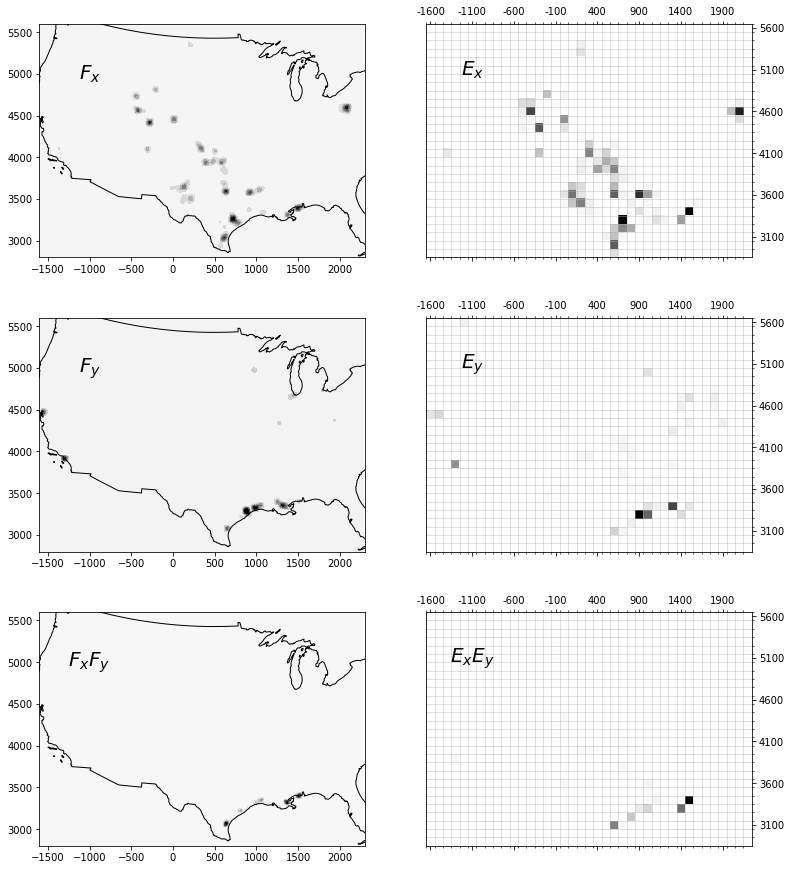

In [198]:
#     x_min = -1600; y_min = 2800
#     x_max = 2300; y_max = 5600

fig, axs = plt.subplots(3, 2, figsize = (12, 13))

# CONTINUOUS PLOTS
ax = axs[0, 0]
ax.contourf(x_[0],y_[0],z_cump_l[0], vmin = 0, vmax = 30, cmap = 'Greys')
US['geometry'].plot(facecolor="none", edgecolor = 'k', ax = ax)
ax.set_xlim(-1600, 2300)
ax.set_ylim(2800, 5600)
ax.set_aspect('equal')

ax = axs[1, 0]
h = ax.contourf(x_[1],y_[1],z_cump_l[1], vmin = 0, vmax = 50, cmap = 'Greys')
US['geometry'].plot(facecolor="none", edgecolor = 'k', ax = ax)
ax.set_xlim(-1600, 2300)
ax.set_ylim(2800, 5600)
ax.set_aspect('equal')

ax = axs[2, 0]
h = ax.contourf(x_[0],y_[0],z_cump_l[0] * z_cump_l[1], vmin = 0, vmax = 350, cmap = 'Greys')
US['geometry'].plot(facecolor="none", edgecolor = 'k', ax = ax)
ax.set_xlim(-1600, 2300)
ax.set_ylim(2800, 5600)
ax.set_aspect('equal')

# DISCRETE PLOTS

ax = axs[0, 1]
data_df = disc_l[0].unstack()['value'].T
data_df = data_df.reindex(np.arange(5600, 2800, -100)).fillna(0)
data_df = data_df.reindex(np.arange(-1600, 2300, 100), axis = 1).fillna(0)
ax.matshow(data_df, cmap = 'Greys')
ax.set_xticks(range(len(data_df.columns))[::5])
ax.set_xticklabels(data_df.columns[::5])
ax.set_yticks(range(len(data_df.index))[::5])
ax.set_yticklabels(data_df.index[::5])

ax.set_xticks(np.arange(-.5, len(data_df.columns)-1, 1), minor=True)
ax.set_yticks(np.arange(-.5, len(data_df.index) - 1, 1), minor=True)
ax.grid(which='minor', alpha=.5)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_aspect('equal')


ax = axs[1, 1]
data_df = disc_l[1].unstack()['value'].T
data_df = data_df.reindex(np.arange(5600, 2800, -100)).fillna(0)
data_df = data_df.reindex(np.arange(-1600, 2300, 100), axis = 1).fillna(0)
ax.matshow(data_df, cmap = 'Greys')
ax.set_xticks(range(len(data_df.columns))[::5])
ax.set_xticklabels(data_df.columns[::5])
ax.set_yticks(range(len(data_df.index))[::5])
ax.set_yticklabels(data_df.index[::5])
ax.set_xticks(np.arange(-.5, len(data_df.columns)-1, 1), minor=True)
ax.set_yticks(np.arange(-.5, len(data_df.index) - 1, 1), minor=True)
ax.grid(which='minor', alpha=.5)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_aspect('equal')

ax = axs[2, 1]
data_df = (disc_l[0]*disc_l[1]).unstack().fillna(0)['value'].T.sort_index(ascending = False)
data_df = data_df.reindex(np.arange(5600, 2800, -100)).fillna(0)
data_df = data_df.reindex(np.arange(-1600, 2300, 100), axis = 1).fillna(0)
ax.matshow(data_df, cmap = 'Greys')
ax.set_xticks(range(len(data_df.columns))[::5])
ax.set_xticklabels(data_df.columns[::5])
ax.set_yticks(range(len(data_df.index))[::5])
ax.set_yticklabels(data_df.index[::5])

ax.set_xticks(np.arange(-.5, len(data_df.columns)-1, 1), minor=True)
ax.set_yticks(np.arange(-.5, len(data_df.index) - 1, 1), minor=True)
ax.grid(which='minor', alpha=.5)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_aspect('equal')


axs[0, 0].annotate(r'$F_x$', xy = (-1000, 5000), fontsize = 20, ha = 'center', va = 'center')
axs[1, 0].annotate(r'$F_y$', xy = (-1000, 5000), fontsize = 20, ha = 'center', va = 'center')
axs[2, 0].annotate(r'$F_x F_y$', xy = (-1000, 5000), fontsize = 20, ha = 'center', va = 'center')

axs[0, 1].annotate(r'$E_x$', xy = (5, 5), fontsize = 20, ha = 'center', va = 'center')
axs[1, 1].annotate(r'$E_y$', xy = (5, 5), fontsize = 20, ha = 'center', va = 'center')
axs[2, 1].annotate(r'$E_x E_y$', xy = (5, 5), fontsize = 20, ha = 'center', va = 'center')
# axs[2, 1].get_xlim()
# axs[2, 1].get_ylim()

# plt.show()

# axs[1, 0].set_axis_off()
# axs[1, 1].set_axis_off()

plt.tight_layout(pad = 4)
# plt.savefig('./areal_point_demo.png')

In [329]:
from matplotlib.ticker import ScalarFormatter

In [199]:
# Test. One plant per county.
# indu_p = indu_p.groupby('AREA_FIPS').first().reset_index()

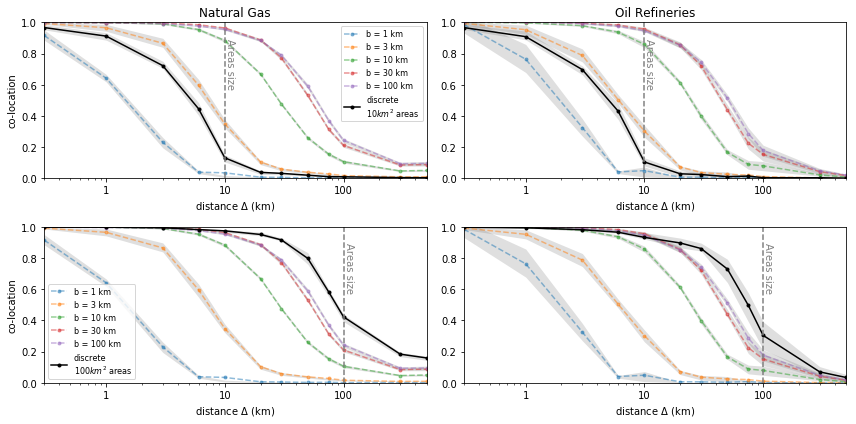

In [332]:
n_widths = result_continuous.b_width.nunique()

fig, axs = plt.subplots(n_industries, n_grids, figsize = (12, 6))


for j in range(result_continuous.industry.nunique()):
    indu = result_continuous.industry.unique()[j]
    for i in range(result_discrete.grid_size.nunique()):

        for k in range(n_widths):
            bw = result_continuous.b_width.unique()[k]
            ax = axs[i][j]
            data = result_continuous.loc[(result_continuous.b_width == bw) & (result_continuous.industry == indu)]
            data['mean'].plot(marker = '.', linestyle = '--', alpha = .5, ax = ax)
            ax.fill_between(data.index.values, data.q25, data.q75, color = '.5', alpha = .25, lw = 0)
            ax.set_xscale('log')
            ax.set_ylim(0, 1)
            if i == 0: ax.set_title(indu)
            if j == 0: ax.set_ylabel('co-location')


for j in range(result_discrete.industry.nunique()):
    indu = result_discrete.industry.unique()[j]
    for i in range(result_discrete.grid_size.nunique()):
        gs = result_discrete.grid_size.unique()[i]
        ax = axs[i][j]
        data = result_discrete.loc[(result_discrete.grid_size == gs) & (result_discrete.industry == indu)]
        data['mean'].plot(marker = '.', color = 'k', ax = ax)
        ax.fill_between(data.index.values, data.q25, data.q75, color = '.5', alpha = .25, lw = 0)
        ax.set_xscale('log')
        ax.set_ylim(0, 1)

        # Size of admin areas
        ax.axvline(gs, color = '.5', linestyle = '--')
        ax.text([10, 100][i], .9, 'Areas size' ,rotation=-90, va='top', color = '.5', fontsize = 10)

        if i == 0: ax.set_title(indu)
        if i == 1: ax.set_xlabel(r'distance $\Delta$ (km)')
        else: ax.set_xlabel(r'distance $\Delta$ (km)')
            
        ax.xaxis.set_major_formatter(ScalarFormatter())

        if j ==0: 
            ax.legend(['b = '+str(w)+' km' for w in widths] + ['discrete\n'+str([10, 100][i])+r'$km^2$'+' areas'],
                     prop={'size': 8})


plt.tight_layout()
# plt.savefig('./cont_disc_simu.png')
plt.show()

#### Single plot

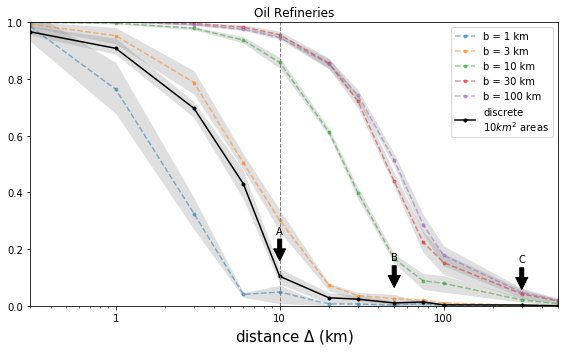

In [302]:

fig, axs = plt.subplots(1, figsize = (8, 5))
ax = axs#[i][j]

n_widths = result_continuous.b_width.nunique()
j = 1; i = 0
indu = result.industry.unique()[j]

for k in range(n_widths):
    bw = result_continuous.b_width.unique()[k]
    data = result_continuous.loc[(result_continuous.b_width == bw) & (result_continuous.industry == indu)]
    data['mean'].plot(marker = '.', linestyle = '--', alpha = .5, ax = ax)
    ax.fill_between(data.index.values, data.q25, data.q75, color = '.5', alpha = .25, lw = 0)
    ax.set_xscale('log')
    ax.set_ylim(0, 1)
    if i == 0: ax.set_title(indu)
    if j == 0: ax.set_ylabel('co-location')

gs = result_discrete.grid_size.unique()[i]

data = result_discrete.loc[(result_discrete.grid_size == gs) & (result_discrete.industry == indu)]
data['mean'].plot(marker = '.', color = 'k', ax = ax)
ax.fill_between(data.index.values, data.q25, data.q75, color = '.5', alpha = .25, lw = 0)

ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.axvline(gs, color = '.5', linestyle = '--', lw = 1)
if i == 0: ax.set_title(indu)
ax.set_xlabel(r'distance $\Delta$ (km)', fontsize = 15)
    
ax.legend(['b = '+str(w)+' km' for w in widths] + ['discrete\n'+r'$10km^2$'+' areas'])
ax.xaxis.set_major_formatter(ScalarFormatter())

# # Annotation of sample Delta values
# for l, w in enumerate([10, 50, 300]):
#     ax.annotate(['A', 'B', 'C'][l], xy=(w, data['mean'].loc[w]+.05), xytext=(w, data['mean'].loc[w] + .15), ha = 'center',
#                 arrowprops=dict(facecolor='black', shrink=0.05),)


plt.tight_layout()
# plt.savefig('./cont_disc_simu.png')
plt.show()

0.10403892617799146

[]

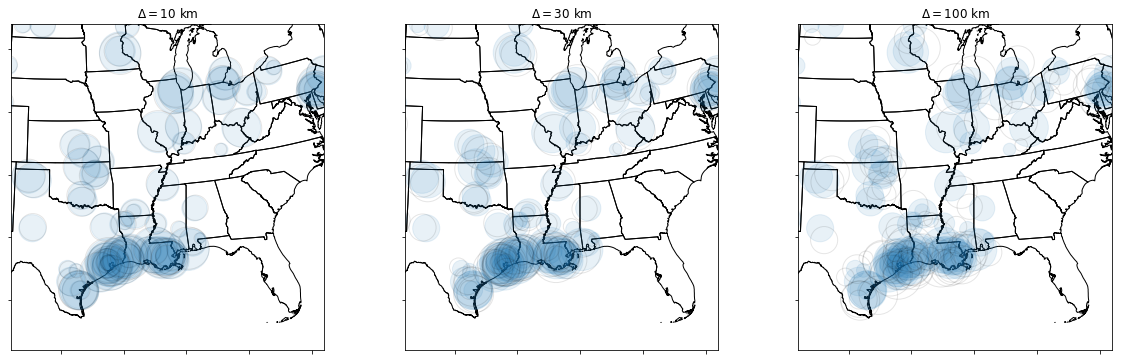

In [287]:
fig, axs = plt.subplots(1, 3, figsize = (20, 6))

dist = [10, 30, 100]; D = len(dist);
j = 1
indu_p, indu_q = indu_loc_info[j]
point_scale = 50
    
for d in range(3):
    ax = axs[d]
    ax.set_title(r'$\Delta = $'+str(dist[d])+' km')
    US_states['geometry'].plot(facecolor="none", edgecolor = 'k', ax = ax)

    ax.scatter(indu_p['loc_x'], indu_p['loc_y'], 
               s = point_scale*np.sqrt(indu_p['value']), alpha = .1)#, edgecolor = 'k')

    ### Create jittered Q industry locations
    # For industry q, copy industry p, and apply an increasing jitter. 
    indu_q = indu_p.copy()[['value', 'geometry']].reset_index(drop = True)

    cov_results = np.zeros((D, N))
    x_0 = indu_p['loc_x']
    y_0 = indu_p['loc_y']

    
    # For each distance d
    # Only one repetition. Set the name of the x, y columns. 
    x_col = 'loc_d'+str(d)+'n'+str(n)+'_x'
    y_col = 'loc_d'+str(d)+'n'+str(n)+'_y'

    # Random choose angle, shift original x, y by d.
    angles = np.pi * np.random.uniform(0, 2, len(indu_q))
    x_d = dist[d] * np.cos(angles); y_d = dist[d] * np.sin(angles)
    # jittered q locations to column
    jit_values = np.array([x_0, y_0]).T + np.array([x_d, y_d]).T

    indu_q[x_col] = jit_values[:, 0]
    indu_q[y_col] = jit_values[:, 1]

    
    ax.scatter(indu_q['loc_d'+str(d)+'n'+str(n)+'_x'], 
                   indu_q['loc_d'+str(d)+'n'+str(n)+'_y'], 
                   s = point_scale*np.sqrt(indu_q['value']), alpha = .1,
               edgecolor = 'k', c = 'None')

    xmin, xmax = 100, 600
    ymin, ymax = 3600, 4200

    ax.set_xticks(np.arange(xmin, xmax, 100), minor=True)
    ax.set_yticks(np.arange(ymin, ymax, 100), minor=True)
    ax.grid(which='minor', alpha=.5)
    
#     xmin, xmax = 100, 2600
#     ymin, ymax = 2600, 5200
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.plot()

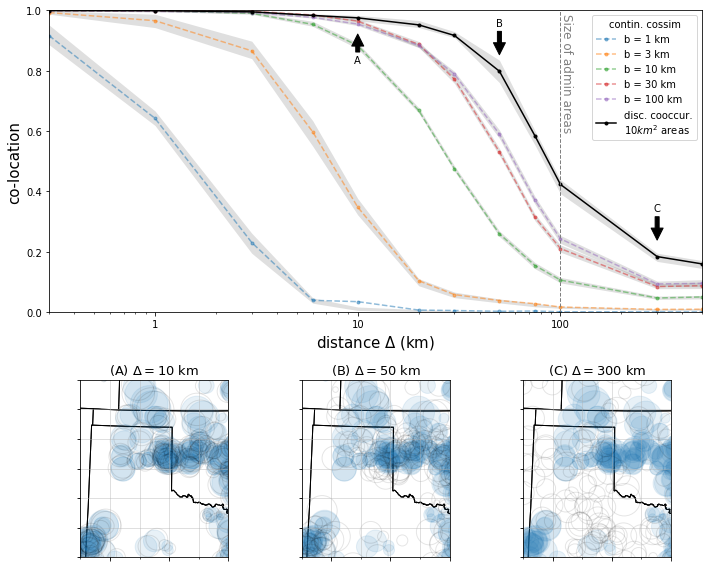

In [333]:
from matplotlib import gridspec

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[1.7, 1]) 

#### COEXISTENCE DECAY PLOT
ax = plt.subplot(gs[0, :])
n_widths = result_continuous.b_width.nunique()
j = 0; i = 1
indu = result.industry.unique()[j]

for k in range(n_widths):
    bw = result_continuous.b_width.unique()[k]
    data = result_continuous.loc[(result_continuous.b_width == bw) & (result_continuous.industry == indu)]
    data['mean'].plot(marker = '.', linestyle = '--', alpha = .5, ax = ax)
    ax.fill_between(data.index.values, data.q25, data.q75, color = '.5', alpha = .25, lw = 0)
    ax.set_xscale('log')
    ax.set_ylim(0, 1)
    if i == 0: ax.set_title(indu)
    if j == 0: ax.set_ylabel('co-location', fontsize = 15)

gsize = result_discrete.grid_size.unique()[i]

data = result_discrete.loc[(result_discrete.grid_size == gsize) & (result_discrete.industry == indu)]
data['mean'].plot(marker = '.', color = 'k', ax = ax)
ax.fill_between(data.index.values, data.q25, data.q75, color = '.5', alpha = .25, lw = 0)

ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.axvline(gsize, color = '.5', linestyle = '--', lw = 1)
ax.text([10, 100][i], .99, 'Size of admin areas' ,rotation=-90, va='top', color = '.5', fontsize = 12)
if i == 0: ax.set_title(indu)
ax.set_xlabel(r'distance $\Delta$ (km)', fontsize = 15)
    
ax.legend(['b = '+str(w)+' km' for w in widths] + ['disc. cooccur.\n'+r'$10km^2$'+' areas'], title="contin. cossim")
ax.xaxis.set_major_formatter(ScalarFormatter())


# Annotation of sample Delta values
for l, w in enumerate([10, 50, 300]):
    if l == 0: # First one below line
        ax.annotate(['A', 'B', 'C'][l], xy=(w, data['mean'].loc[w] - .05), xytext=(w, data['mean'].loc[w] - .15), ha = 'center',
            arrowprops=dict(facecolor='black', shrink=0.05),)
    else:
        ax.annotate(['A', 'B', 'C'][l], xy=(w, data['mean'].loc[w]+.05), xytext=(w, data['mean'].loc[w] + .15), ha = 'center',
            arrowprops=dict(facecolor='black', shrink=0.05),)


### MAP PLOTS

dist = [10, 50, 300]; D = len(dist);
j = 0
indu_p, indu_q = indu_loc_info[j]
point_scale = 50

for d in range(3):
#     ax = axs[d]
    ax = plt.subplot(gs[1, d])
    ax.set_title(['(A) ', '(B) ', '(C) '][d]+r'$\Delta = $'+str(dist[d])+' km', fontsize = 13)
    US_states['geometry'].plot(facecolor="none", edgecolor = 'k', ax = ax)

    ax.scatter(indu_p['loc_x'], indu_p['loc_y'], 
               s = point_scale*np.sqrt(indu_p['value']), alpha = .1)#, edgecolor = 'k')

    ### Create jittered Q industry locations
    # For industry q, copy industry p, and apply an increasing jitter. 
    indu_q = indu_p.copy()[['value', 'geometry']].reset_index(drop = True)

    cov_results = np.zeros((D, N))
    x_0 = indu_p['loc_x']
    y_0 = indu_p['loc_y']

    
    # For each distance d
    # Only one repetition. Set the name of the x, y columns. 
    x_col = 'loc_d'+str(d)+'n'+str(n)+'_x'
    y_col = 'loc_d'+str(d)+'n'+str(n)+'_y'

    # Random choose angle, shift original x, y by d.
    angles = np.pi * np.random.uniform(0, 2, len(indu_q))
    x_d = dist[d] * np.cos(angles); y_d = dist[d] * np.sin(angles)
    # jittered q locations to column
    jit_values = np.array([x_0, y_0]).T + np.array([x_d, y_d]).T

    indu_q[x_col] = jit_values[:, 0]
    indu_q[y_col] = jit_values[:, 1]

    
    ax.scatter(indu_q['loc_d'+str(d)+'n'+str(n)+'_x'], 
                   indu_q['loc_d'+str(d)+'n'+str(n)+'_y'], 
                   s = point_scale*np.sqrt(indu_q['value']), alpha = .1,
               edgecolor = 'k', c = 'None')

    xmin, xmax = 100, 600
    ymin, ymax = 3600, 4200

    ax.set_xticks(np.arange(xmin, xmax, 100), minor=True)
    ax.set_yticks(np.arange(ymin, ymax, 100), minor=True)
    ax.grid(which='minor', alpha=.5)
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    

plt.tight_layout()
plt.savefig('./distance_decay_demo.png')
plt.show()